In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import string
import re

from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout


#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

---
# NLP using LSTM

References:

https://www.kaggle.com/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm/notebook#10.-Model-creation-Using-LSTM

https://en.wikipedia.org/wiki/Cosine_similarity

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [2]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_train.csv')

unseentest=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_test.csv')

#for kaggle
#train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#unseentest = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


In [3]:
train.text.values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [4]:
print(train.shape)

(7613, 5)


In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# 1 = disaster

train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
train.keyword.nunique()

221

In [8]:
chains=train.keyword.value_counts()[:20]
chains


fatalities     45
deluge         42
armageddon     42
body%20bags    41
harm           41
damage         41
sinking        41
collided       40
siren          40
windstorm      40
twister        40
outbreak       40
evacuate       40
fear           40
whirlwind      39
wrecked        39
explosion      39
earthquake     39
wreckage       39
flames         39
Name: keyword, dtype: int64

Text(0.5, 1.0, 'nondisasters')

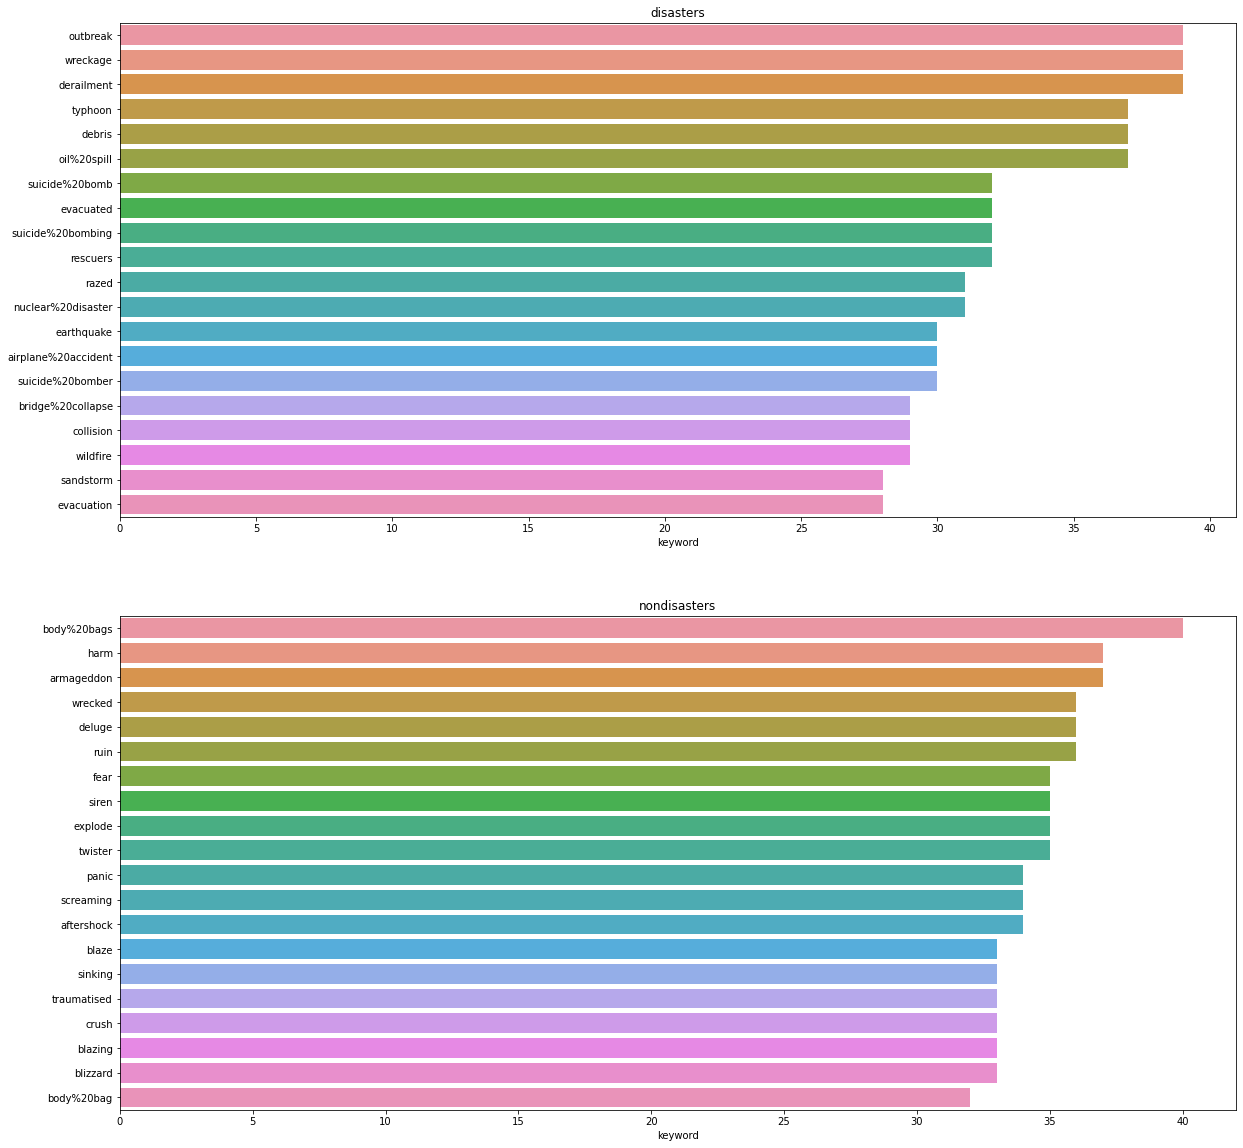

In [9]:
disaster =train.loc[train.target==1]['keyword'].value_counts()
nondisaster=train.loc[train.target==0]['keyword'].value_counts() 

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(20,20))
sns.barplot(y=disaster[0:20].index,x=disaster[0:20],ax=ax[0],orient='h')
ax[0].set_title('disasters')

sns.barplot(y=nondisaster[0:20].index,x=nondisaster[0:20],ax=ax[1],orient='h')
ax[1].set_title('nondisasters')


In [10]:
disaster

outbreak       39
wreckage       39
derailment     39
typhoon        37
debris         37
               ..
ruin            1
blazing         1
electrocute     1
body%20bags     1
body%20bag      1
Name: keyword, Length: 220, dtype: int64

In [11]:
#removing punctuations are part of preprocessing since they aren't needed

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
def toclean_text(text):
  clean_text=[char for char in text if char not in string.punctuation]
  clean_text=''.join(clean_text)
  return clean_text

In [13]:
train['clean_text']=train.text.apply(toclean_text)


In [14]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...


In [15]:
#removing abbreviations noise

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [16]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

# Remove all emojis, replace by EMOJI
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)

# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

In [17]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [18]:
train.clean_text = train.clean_text.apply(clean_tweet)
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NUMBER people receive wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...


Here Keras Tokenizer() is used which is supported by Tensorflow as a high-level API that encodes the token to a numerical value. The main reason to use this is in LSTM input is provided by embedding layer, which requires input data to be integer encoded.

In [19]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train.clean_text.values)
X = tokenizer.texts_to_sequences(train.clean_text.values)
X = pad_sequences(X)

In [20]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  109,   22,
          1,  825,    6,   19,  243,  126, 1550,   70,   38], dtype=int32)

In [21]:
tokenizer.sequences_to_texts([[ 109,  22,   1, 825,6,19,243,126,1550,70,38]])

['our are the reason of this earthquake may allah us all']

Model creation using LSTM

In [22]:
y=train.target

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)

In [24]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 31, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
191/191 [==============================] - 8s 30ms/step - loss: 0.5374 - accuracy: 0.7269 - val_loss: 0.4385 - val_accuracy: 0.8011
Epoch 2/10
191/191 [==============================] - 5s 27ms/step - loss: 0.3871 - accuracy: 0.8305 - val_loss: 0.4462 - val_accuracy: 0.7951
Epoch 3/10
191/191 [==============================] - 5s 27ms/step - loss: 0.3333 - accuracy: 0.8619 - val_loss: 0.4658 - val_accuracy: 0.7886
Epoch 4/10
191/191 [==============================] - 5s 28ms/step - loss: 0.2927 - accuracy: 0.8785 - val_loss: 0.4763 - val_accuracy: 0.7945
Epoch 5/10
191/191 [==============================] - 5s 28ms/step - loss: 0.2590 - accuracy: 0.8954 - val_loss: 0.5553 - val_accuracy: 0.7853
Epoch 6/10
191/191 [==============================] - 6s 30ms/step - loss: 0.2232 - accuracy: 0.9123 - val_loss: 0.5603 - val_accuracy: 0.7905
Epoch 7/10
191/191 [==============================] - 6s 30ms/step - loss: 0.2063 - accuracy: 0.9161 - val_loss: 0.6217 - val_accuracy: 0.7866

In [26]:
y_pred=model.predict(X_test).round()

In [27]:
train_accuracy = round(metrics.accuracy_score(y_train,model.predict(X_train).round())*100)
train_accuracy

96

In [28]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[758, 124],
       [214, 427]])

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       882
           1       0.77      0.67      0.72       641

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



Kaggle Submission

In [30]:
unseentest=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_test.csv')
#,usecols=['text'],
 #                      dtype={'text':str,'target':np.int64})

In [31]:
unseentest['clean_text'] = unseentest['text'].apply(toclean_text)
unseentest["clean_text"] = unseentest["clean_text"].apply(clean_tweet)

In [32]:
unseentest.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills NUMBER in China and Tai...


In [33]:
unseentest.shape

(3263, 5)

In [34]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train.clean_text.values)
X = tokenizer.texts_to_sequences(train.clean_text.values)
X = pad_sequences(X, maxlen =l)

In [35]:
tokenizer.fit_on_texts(train.clean_text.values)
test_token = tokenizer.texts_to_sequences(unseentest['clean_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

In [36]:
embed_dim = 100
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
model.fit(X,y, epochs = 10, batch_size=32)

Epoch 1/10
238/238 [==============================] - 25s 95ms/step - loss: 0.5028 - accuracy: 0.7555
Epoch 2/10
238/238 [==============================] - 23s 97ms/step - loss: 0.3581 - accuracy: 0.8513
Epoch 3/10
238/238 [==============================] - 24s 99ms/step - loss: 0.2825 - accuracy: 0.8844
Epoch 4/10
238/238 [==============================] - 23s 96ms/step - loss: 0.2197 - accuracy: 0.9102
Epoch 5/10
238/238 [==============================] - 24s 101ms/step - loss: 0.1729 - accuracy: 0.9310
Epoch 6/10
238/238 [==============================] - 24s 102ms/step - loss: 0.1426 - accuracy: 0.9423
Epoch 7/10
238/238 [==============================] - 24s 100ms/step - loss: 0.1230 - accuracy: 0.9488
Epoch 8/10
238/238 [==============================] - 23s 98ms/step - loss: 0.1054 - accuracy: 0.9557
Epoch 9/10
238/238 [==============================] - 24s 99ms/step - loss: 0.0924 - accuracy: 0.9611
Epoch 10/10
238/238 [==============================] - 24s 100ms/step - loss: 0

In [38]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission_twitter.csv')
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submission_twitter.csv', index=False)

---
Recurrent NEURAL NETWORK
---


In [40]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [70]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [47]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_train.csv')
unseentest=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_test.csv')

#for kaggle
#train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#unseentest = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


In [48]:
print(train.head())
print(unseentest.head())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [49]:
train = train.drop(['id', 'keyword', 'location'], axis=1) #1 for columns
unseentest = unseentest.drop(['id', 'keyword', 'location'], axis=1)

In [53]:
y_train=train['target'].values 
X_train=train.drop(['target'],axis=1).values.reshape(len(train),)
X_test=unseentest['text'].values.reshape(len(unseentest),)

In [55]:
total_tweets =np.concatenate((X_train,X_test))
print('total tweet ', len(total_tweets))

total tweet  10876


In [56]:
#Tokenization is the process of turning a meaningful piece of data, such as an account number,
#into a random string of characters called a token that has no meaningful value if breached. 
#Tokens serve as reference to the original data, but cannot be used to guess those values.
tokenizer =Tokenizer()
tokenizer.fit_on_texts(total_tweets)

#vocab size
vocab_size=len(tokenizer.word_index) + 1
print('size of vocab ',vocab_size)

size of vocab  29320


In [57]:
maxlen=max(len(x.split()) for x in total_tweets)
print('max len of tweet ',maxlen)

max len of tweet  31


In [58]:
X_train_token=tokenizer.texts_to_sequences(X_train)
X_test_token=tokenizer.texts_to_sequences(X_test)
print('untokenized')
print(X_train[0])
print('\n tokenized')
print(X_train_token[0])

untokenized
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

 tokenized
[114, 5944, 24, 4, 850, 8, 21, 253, 151, 1820, 3841, 88, 41]


In [63]:
X_train_pad = pad_sequences(X_train_token, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_token, maxlen=maxlen, padding='post')

print('untokenized')
print(X_train_token[0])
print('\n tokenized')
print(X_train_pad[0])

untokenized
[114, 5944, 24, 4, 850, 8, 21, 253, 151, 1820, 3841, 88, 41]

 tokenized
[ 114 5944   24    4  850    8   21  253  151 1820 3841   88   41    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0]


In [64]:
hidden_units=128
embed_units=100

model=Sequential()
model.add(Embedding(vocab_size,embed_units,input_length=maxlen))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.3))

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 100)           2932000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                      

In [65]:
learning_rate=.0001
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
batch_size=512
num_itr=5
model_history=model.fit(X_train_pad,y_train,
                        batch_size=batch_size,
                        epochs=num_itr,
                        validation_split=.2)

Epoch 1/7
12/12 [==============================] - 6s 539ms/step - loss: 0.0549 - accuracy: 0.9813 - val_loss: 0.8354 - val_accuracy: 0.7328
Epoch 2/7
12/12 [==============================] - 6s 538ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.8127 - val_accuracy: 0.7702
Epoch 3/7
12/12 [==============================] - 6s 536ms/step - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.9498 - val_accuracy: 0.7242
Epoch 4/7
12/12 [==============================] - 6s 542ms/step - loss: 0.0265 - accuracy: 0.9918 - val_loss: 1.1052 - val_accuracy: 0.7728
Epoch 5/7
12/12 [==============================] - 7s 545ms/step - loss: 0.0285 - accuracy: 0.9893 - val_loss: 1.0210 - val_accuracy: 0.7511
Epoch 6/7
12/12 [==============================] - 6s 544ms/step - loss: 0.0224 - accuracy: 0.9944 - val_loss: 0.7999 - val_accuracy: 0.7636
Epoch 7/7
12/12 [==============================] - 7s 548ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 1.0031 - val_accuracy: 0.7511


Kaggle Submission

In [72]:
y_hat = model.predict(X_test_pad).round()
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission_twitter.csv')
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/submission_twitter_rnn.csv', index=False)

# Another RNN

https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

In [130]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [109]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rnn_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission_twitter.csv')

#for kaggle
#train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
#unseentest = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [111]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) #in a re.sub, the second part '' is to replace with empty string
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

See different types of tokenizers below

In [114]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("------------------------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
------------------------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [115]:
# Tokenizing the training and the test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [123]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


To see as example what stopwords are removed below:

In [127]:
stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

Stemming removes suffixes to get to the root words, for example cats = cat. Lemmatization returns the base or dictionary for of the word.

In [132]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

# Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


In [137]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [138]:
# text preprocessing function
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

Bag of Words approach - Countvectorizer below converts texts to matrix of token counts which has ability to preprocess, tokenize, and remove stop words. It was already done above however this is shown below as reference.


In [151]:
count_vectorizer=CountVectorizer()
train_vectors=count_vectorizer.fit_transform(train.text)
test_vectors=count_vectorizer.transform(test.text)

print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


Important to note bag of words uses highly frequent words hoever not all may be important. Must rescale frequency by how often they appear in all documents, so taht words like "the" are penalized. Called Term Frequency-Inverse Document Frequency (TF-IDF).

In [154]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train.text)
test_tfidf = tfidf.transform(test.text)

In [155]:
train_tfidf

<7613x11077 sparse matrix of type '<class 'numpy.float64'>'
	with 74640 stored elements in Compressed Sparse Row format>

In [156]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train.target, cv=5, scoring="f1")
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [158]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train.target, cv=5, scoring="f1")
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [162]:
test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety fasten...
3259,10865,NaN,NaN,storm ri worse last hurricane hardest hit yard...
3260,10868,NaN,NaN,green line derailment chicago
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo
